# <font color='#150E0D' style='font-family:Trajan-Pro; font-size: 34px;'> Modelo Preditivo de Aprovação de Crédito </font>
<hr style='border: 3px solid #150E0D'>

# <font color='#150E0D' style='font-family:Trajan-Pro; font-size: 28px;'> Objetivo </font>
<hr style='border: 2px solid #150E0D'>

<p style='line-height: 2; text-align: justify; text-indent: 35px;'> Este notebook tem como objetivo a criação de um modelo preditivo responsável por identificar quais solicitações de crédito possuem maiores chances de se tornarem inadimplentes.  </p>

# <font color='#150E0D' style='font-family:Trajan-Pro; font-size: 28px;'> Bibliotecas Utilizadas </font>
<hr style='border: 2px solid #150E0D'>

In [1]:
# Lista de Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from scipy.stats import normaltest
from typing import List
from xgboost import plot_tree

# <font color='#150E0D' style='font-family:Trajan-Pro; font-size: 28px;'> Dados </font>
<hr style='border: 2px solid #150E0D'>

In [2]:
# Dados de Treino
treino = pd.read_csv("../Dados/treino.csv")

# Removendo Dados Duplicados
treino.drop_duplicates(inplace=True)

treino.head(5)

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
# Dados de Teste
teste = pd.read_csv("../Dados/teste.csv")

# Removendo Dados Duplicados
teste.drop_duplicates(inplace=True)

teste.head(5)

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0


# <font color='#150E0D' style='font-family:Trajan-Pro; font-size: 28px;'>Lidando com os Valores Faltantes </font>
<hr style='border: 2px solid #150E0D'>

<p style='line-height: 2; text-align: justify; text-indent: 35px;'> Antes de criar qualquer modelo de aprendizado de máquinas, é importante verificar se existem valores faltantes no conjunto de dados. Como pode ser observado abaixo, nos dados de treino e teste, existem diversos valores faltantes nas colunas "salario_mensal" e "numero_de_dependentes". Assim, é interessante visualizar o tipo de distribuição dos dados para escolhermos o método de substituição desses valores. </p>

In [4]:
# Dados Faltantes - Treino
treino.isnull().sum()

inadimplente                                 0
util_linhas_inseguras                        0
idade                                        0
vezes_passou_de_30_59_dias                   0
razao_debito                                 0
salario_mensal                           21460
numero_linhas_crdto_aberto                   0
numero_vezes_passou_90_dias                  0
numero_emprestimos_imobiliarios              0
numero_de_vezes_que_passou_60_89_dias        0
numero_de_dependentes                     2821
dtype: int64

In [5]:
# Dados Faltantes - Teste
teste.isnull().sum()

util_linhas_inseguras                       0
idade                                       0
vezes_passou_de_30_59_dias                  0
razao_debito                                0
salario_mensal                           7911
numero_linhas_crdto_aberto                  0
numero_vezes_passou_90_dias                 0
numero_emprestimos_imobiliarios             0
numero_de_vezes_que_passou_60_89_dias       0
numero_de_dependentes                    1037
dtype: int64

<p style='line-height: 2; text-align: justify; text-indent: 35px;'> Após criar um histograma da variável "salário_mensal", fica evidente que a amplitude da escala decimal não proporciona uma boa visualização. Uma solução simples para esse tipo de problema é transformar todos os valores dessa coluna para a escala logarítmica. </p>
    
<p style='line-height: 2; text-align: justify; text-indent: 35px;'>Ao analisar o histograma da variavel "salario_mensal" na escala logarítmica, observa-se que sua distribuição lembra uma distribuição normal, porém, com assimetria tanto à esquerda quando à direita. Para ter certeza sobre o tipo da distribuição, é feito um teste de normalidade, onde foi constatado que a distribuição não é normal.  </p>

C:\Users\paulo\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distribuição de Frequências - Treino'}, xlabel='Salário Mensal (R$)', ylabel='Density'>

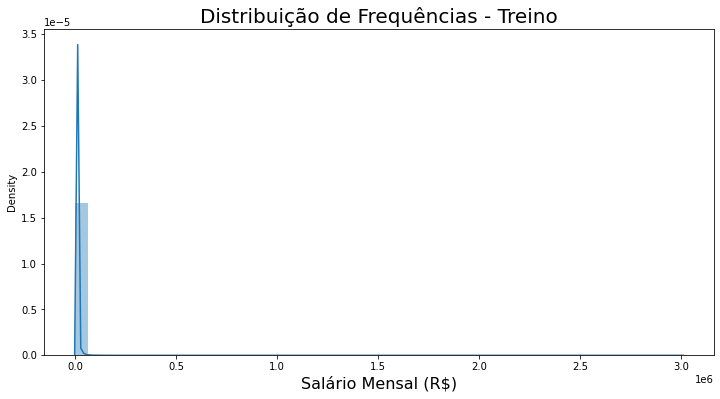

In [6]:
# Histograma do log do salário mensal
ax = sns.distplot(treino['salario_mensal'])
ax.figure.set_size_inches(12, 6)
ax.set_title('Distribuição de Frequências - Treino', fontsize=20)
ax.set_xlabel('Salário Mensal (R$)', fontsize=16)
ax

C:\Users\paulo\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distribuição de Frequências - Treino'}, xlabel='Log do Salário Mensal (R$)', ylabel='Density'>

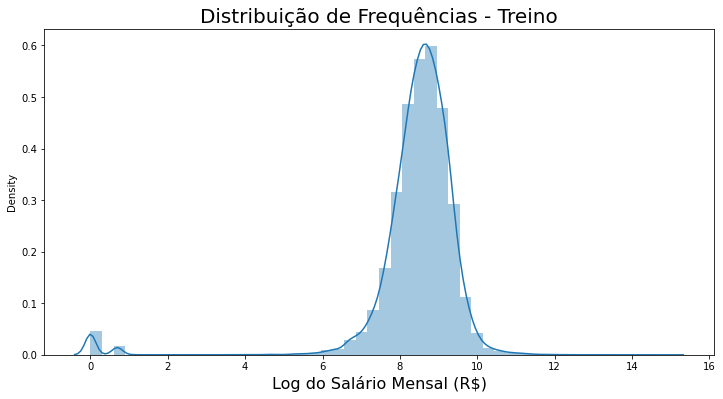

In [7]:
# Visualização da Distribuição das Variáveis Faltantes
log_salario_treino = np.log(treino['salario_mensal'] + 1)

# Histograma do log do salário mensal
ax = sns.distplot(log_salario_treino)
ax.figure.set_size_inches(12, 6)
ax.set_title('Distribuição de Frequências - Treino', fontsize=20)
ax.set_xlabel('Log do Salário Mensal (R$)', fontsize=16)
ax

C:\Users\paulo\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distribuição de Frequências - Teste'}, xlabel='Log do Salário Mensal (R$)', ylabel='Density'>

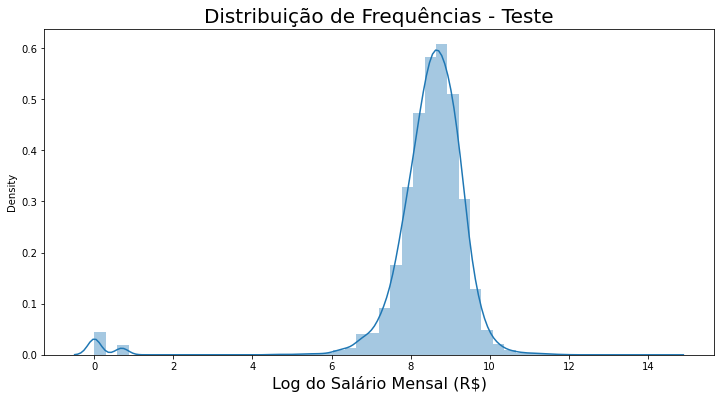

In [8]:
# Visualização da Distribuição das Variáveis Faltantes
log_salario_teste = np.log(teste['salario_mensal'] + 1)

# Histograma do log do salário mensal
ax = sns.distplot(log_salario_teste)
ax.figure.set_size_inches(12, 6)
ax.set_title('Distribuição de Frequências - Teste', fontsize=20)
ax.set_xlabel('Log do Salário Mensal (R$)', fontsize=16)
ax

In [9]:
def teste_de_normalidade(dados: List[float], alpha: float) -> str:
    # Realiza um teste de normalidade dos dados inseridos, retornando uma str dizendo se segue, ou não, uma distribuição normal
    stats, pvalue = normaltest(dados, nan_policy='omit')
    if pvalue < alpha:
        return f"Os dados não seguem uma distribuição normal. O valor de p é {pvalue}"
               
    else:
        return f"Os dados seguem uma distribuição normal. O valor de p é {pvalue}"

In [10]:
# Teste de normalidade dos salário - Treino
teste_de_normalidade(treino['salario_mensal'], 0.05)

'Os dados não seguem uma distribuição normal. O valor de p é 0.0'

In [11]:
# Teste de normalidade dos salário - Teste
teste_de_normalidade(teste['salario_mensal'], 0.05)

'Os dados não seguem uma distribuição normal. O valor de p é 0.0'

<p style='line-height: 2; text-align: justify; text-indent: 35px;'> Assim, a análise do tipo de distribuição é importante para definir qual das medidas de tendência central deve ser utilizada para preencher os valores faltantes. Se as distribuições fossem normais, a média seria a medida ideal para preencher esses valores. No entanto, por se tratrar de uma distribuição assimétria, a média é drasticamente afetada pelos valores das extremidades. Dessa forma, é aconselhável utilizar a mediana para o preenchimento dos valores faltantes.</p>

In [12]:
# Preenchendo os valores faltantes
treino['salario_mensal'].fillna(value=treino['salario_mensal'].median(), inplace=True)
teste['salario_mensal'].fillna(value=teste['salario_mensal'].median(), inplace=True)

<p style='line-height: 2; text-align: justify; text-indent: 35px;'> Para o número de dependentes, vamos utilizar a média para preencher os valores faltantes. Demograficamente, a tendência é que as pessoas tenham poucos filhos. Assim, é bem provável que valores entre 0-2 estejam mais coerentes com a realidade do que valores maiores (5+).</p>

In [13]:
# Preenchendo os valores faltantes
treino['numero_de_dependentes'].fillna(value=round(treino['numero_de_dependentes'].mean(), 0), inplace=True)
teste['numero_de_dependentes'].fillna(value=round(teste['numero_de_dependentes'].mean(), 0), inplace=True)

In [14]:
# Dados Faltantes - Teste
treino.isnull().sum()

inadimplente                             0
util_linhas_inseguras                    0
idade                                    0
vezes_passou_de_30_59_dias               0
razao_debito                             0
salario_mensal                           0
numero_linhas_crdto_aberto               0
numero_vezes_passou_90_dias              0
numero_emprestimos_imobiliarios          0
numero_de_vezes_que_passou_60_89_dias    0
numero_de_dependentes                    0
dtype: int64

# <font color='#150E0D' style='font-family:Trajan-Pro; font-size: 28px;'> Distribuição por Classe </font>
<hr style='border: 2px solid #150E0D'>

<p style='line-height: 2; text-align: justify; text-indent: 35px;'> As classes correspondem aos possíveis valores que as instâncias da “coluna resposta” podem assumir. Para este projeto, temos apenas duas  possíveis classes, sendo elas 0 e 1. O valor 0 na coluna resposta indica que o cliente está Adimplente com suas obrigações perante o banco. Analogamente, o valor 1 indica que ele está Inadimplente. </p>

<p style='line-height: 2; text-align: justify; text-indent: 35px;'> Ao visualizar o gráfico de barras abaixo, fica evidente que existe um grande desbalanceamento no número de instâncias dos dados de treino. Existem 102.319 instâncias adimplentes enquanto a classe inadimplente possui apenas 7.318. Esse desbalanceamento entre as classes nos dados de treino pode propiciar que o algoritmo de aprendizado sofra enviesamento. </p>

<AxesSubplot:title={'center':'Distribuição das Classes'}, xlabel='Status', ylabel='Quantidade'>

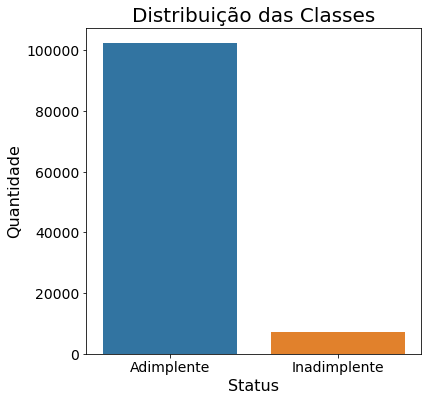

In [15]:
# Distribuição das classes
ax = sns.barplot(x=['Adimplente', 'Inadimplente'], y=treino['inadimplente'].value_counts())
ax.figure.set_size_inches(6, 6)
ax.set_title('Distribuição das Classes', fontsize=20)
ax.set_xlabel('Status', fontsize=16)
ax.set_ylabel('Quantidade', fontsize=16)
ax.tick_params(labelsize=14)
ax

In [16]:
df = pd.DataFrame(data=treino['inadimplente'].value_counts())
df['Porcentagem'] = round(treino['inadimplente'].value_counts(normalize=True),2)
df.rename(columns={"inadimplente":"Quantidades"}, index={0:"Adimplente", 1:"Inadimplente"}, inplace=True)
df

,Quantidades,Porcentagem
Adimplente,102319,0.93
Inadimplente,7318,0.07


<p style='line-height: 2; text-align: justify; text-indent: 35px;'> Para evitar esse possível enviesamento, será  aplicado a técnica de Undersampling, Ela consiste em limitar o número de instâncias de acordo com a classe menos predominante. Assim, serão excluídas as instâncias sobressalentes da classe adimplente, deixando o novo conjunto de dados com a mesma quantidade de dados de cada classe. </p>

In [17]:
# Semente
SEED = 42
np.random.seed(SEED)

In [18]:
# Calculando a quantidade de linhas a serem dropadas
qnt_linhas_dropadas = df['Quantidades'].iloc[0] - df['Quantidades'].iloc[1]
qnt_linhas_dropadas

95001

In [19]:
# Selecionando uma amostra dentro da classe adimplente
filtro = treino['inadimplente'] == 0
linhas_dropadas = treino[filtro].sample(qnt_linhas_dropadas)

# Removendo as linhas selecionadas na amostragem
treino.drop(linhas_dropadas.index, inplace=True)

<AxesSubplot:title={'center':'Distribuição das Classes'}, xlabel='Status', ylabel='Quantidade'>

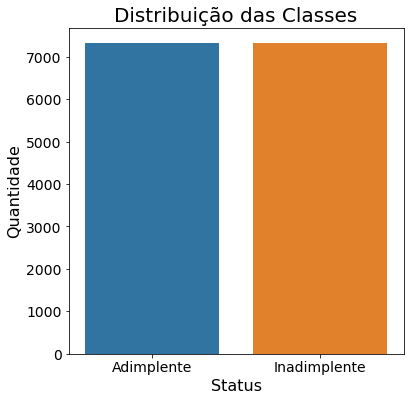

In [20]:
# Distribuição das classes
ax = sns.barplot(x=['Adimplente', 'Inadimplente'], y=treino['inadimplente'].value_counts())
ax.figure.set_size_inches(6, 6)
ax.set_title('Distribuição das Classes', fontsize=20)
ax.set_xlabel('Status', fontsize=16)
ax.set_ylabel('Quantidade', fontsize=16)
ax.tick_params(labelsize=14)
ax

# <font color='#150E0D' style='font-family:Trajan-Pro; font-size: 28px;'> Modelo de Aprendizado </font>
<hr style='border: 2px solid #150E0D'>

<p style='line-height: 2; text-align: justify; text-indent: 35px;'> O algoritmo de machine learning escolhido para criação do modelo foi o XGboost. Esse algoritmo é um dos mais amplamente utilizados, principalmente, devido a sua eficácia. Isto se deve ao fato do XGboost ser baseado em duas técnicas de aprendizado de máquinas, sendo elas as árvores de decisão (Decision Trees) e o gradiente booster. A grande vantagem dos modelos baseados em árvores de decisão é que os dados não precisam ser transformados pois as escalas não afetam o desempenho do algoritmo. Outro ponto importante é que o modelo sabe quantificar a importância de cada feature para o processo de aprendizado. Dito isso, fica evidente porque o escolhemos.</p>

In [21]:
# Dados de Treino
X_train = treino.drop(columns=['inadimplente'])
y_train = treino['inadimplente']

In [22]:
# Instanciando o modelo
modelo = xgb.XGBClassifier()

# Se tivessemos os resultados dos testes, seria possível "tunar" o modelo, testando diferentes configuração.
# Como não se tem, deixei ele no modo default.

# Treinando o modelo
modelo.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [23]:
# Predição dos dados de teste
y_pred = modelo.predict(teste)

In [24]:
# Salvando as Predições
teste['inadimplente'] = y_pred
teste.to_csv('../Dados/teste_preditos.csv')
teste.head(5)

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplente
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0,0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0,0
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0,0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0,0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0,0


In [25]:
#plot_tree(modelo, num_trees=0); plt.show()